In [107]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")


# install data

In [108]:
pip install yfinance


In [109]:
import yfinance as yf

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


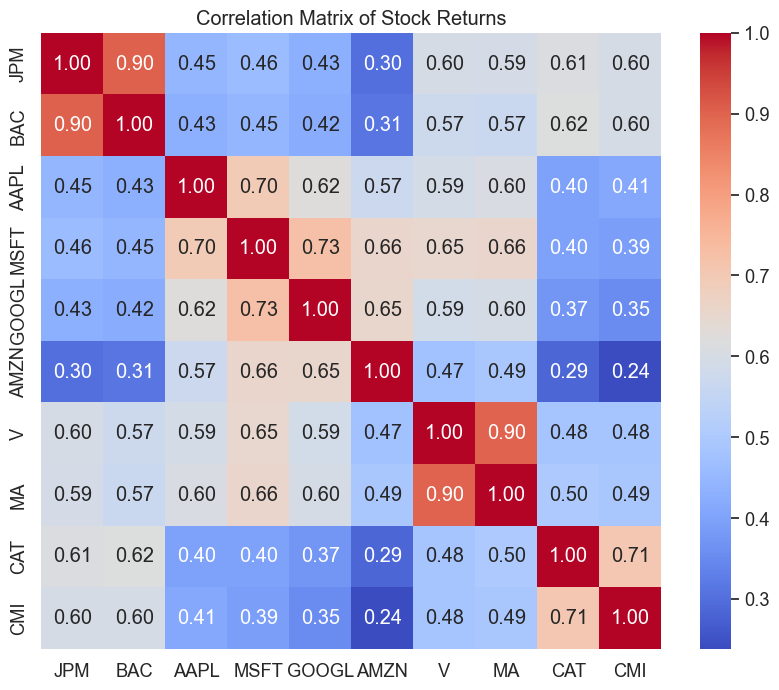

The two companies with the maximum correlation are: ('JPM', 'BAC')
The maximum correlation value is: 0.9032977019743933


In [110]:


# List of companies (tickers), including JPM and BAC
tickers = ['JPM', 'BAC', 'AAPL', 'MSFT', 'GOOGL', 'AMZN' ,'V' ,'MA' ,'CAT' ,'CMI' ]  # Add any other tickers as needed

# Define the time period (Fiscal Year)
start_date = '2015-01-01'
end_date = '2023-12-31'

# Download stock price data for the specified period, handling errors
data = {}
for ticker in tickers:
    try:
        data[ticker] = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Filter out 'FB' from the data dictionary if it was downloaded successfully
tickers = [ticker for ticker in tickers if ticker != 'FB']
data_df = pd.DataFrame(data)

# Calculate daily returns
returns = data_df.pct_change().dropna()

# Compute the correlation matrix
correlation_matrix = returns.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
plt.title('Correlation Matrix of Stock Returns')
plt.show()

# Find the pair of companies with the maximum correlation
correlation_matrix_unstacked = correlation_matrix.unstack()
# Remove self-correlation by setting them to NaN
correlation_matrix_unstacked[correlation_matrix_unstacked == 1] = np.nan

max_correlation_pair = correlation_matrix_unstacked.idxmax()
max_correlation_value = correlation_matrix_unstacked.max()

print(f"The two companies with the maximum correlation are: {max_correlation_pair}")
print(f"The maximum correlation value is: {max_correlation_value}")


# taking jpm and bac for pair trading

In [111]:
start='2015-01-01'
end="2023-01-01"

stock1=yf.Ticker('BAC')
stock1_data=stock1.history(interval='1d' ,start=start ,end=end)

stock2=yf.Ticker('JPM')
stock2_data=stock2.history(interval='1d' ,start=start ,end=end)


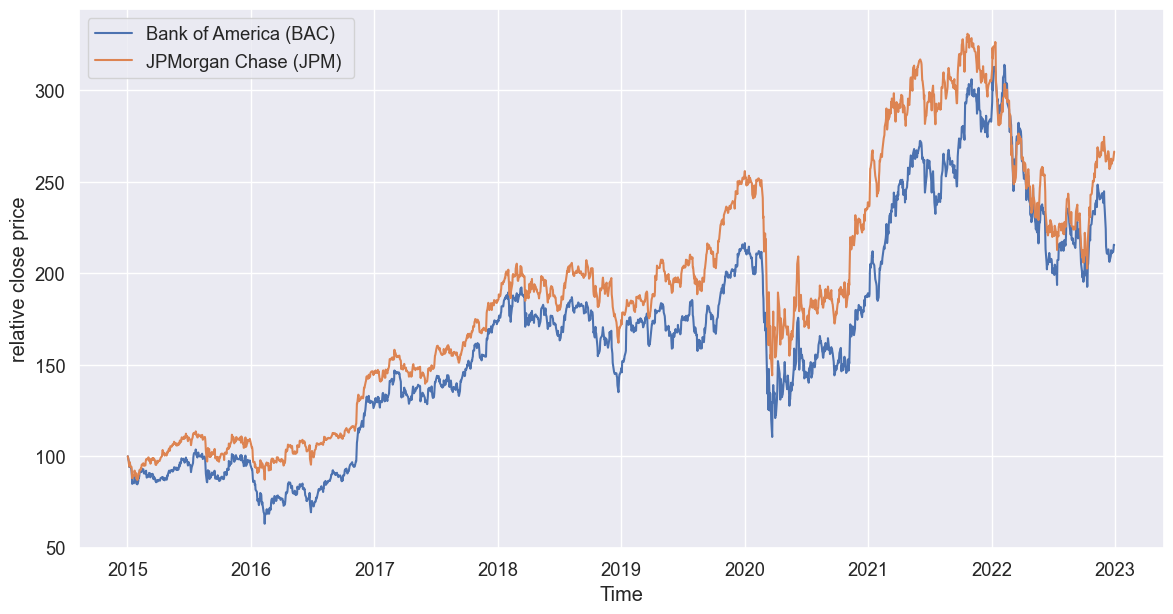

In [112]:
stock1_close_relative=stock1_data["Close"]/stock1_data["Close"][0]*100.
stock2_close_relative=stock2_data["Close"]/stock2_data["Close"][0]*100.
name_stock1 = 'Bank of America (BAC)'

name_stock2 = 'JPMorgan Chase (JPM) '
plt.figure(figsize=(14, 7))
plt.plot(stock1_close_relative ,label =name_stock1)
plt.plot(stock2_close_relative ,label =name_stock2)
plt.xlabel('Time')
plt.ylabel('relative close price')
plt.legend()
plt.grid(True)
plt.show()



# Pairs trading cointegration

estimate linear regression

In [113]:
x=np.log(stock1_data["Close"])
y=np.log(stock2_data["Close"])
x=sm.add_constant(x)
model=sm.OLS(y,x)
results=model.fit()
results.params

#get spread
alpha=results.params.values[0]
beta=results.params.values[1]
error=y-(alpha+x["Close"]*beta)




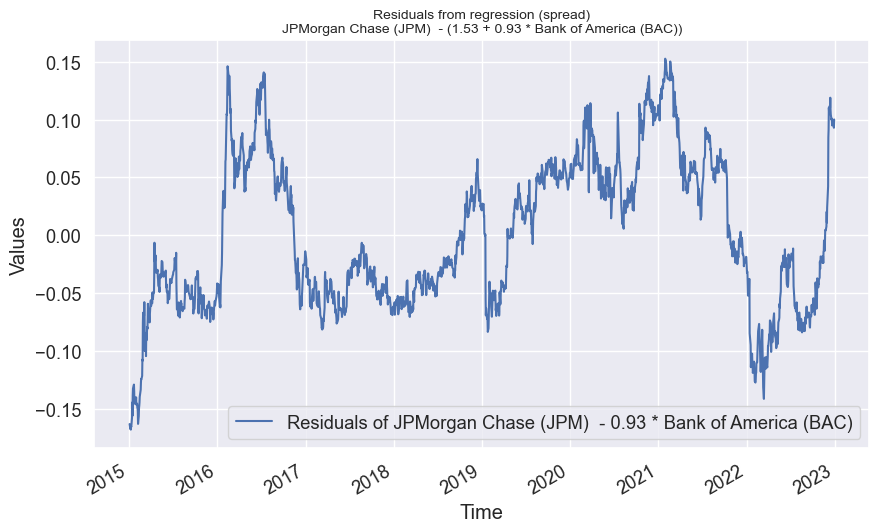

In [114]:
plt.figure(figsize=(10, 6))
error.plot(label=f"Residuals of {name_stock2} - {beta:.2f} * {name_stock1}")
plt.title(f'Residuals from regression (spread)\n{name_stock2} - ({alpha:.2f} + {beta:.2f} * {name_stock1})', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()


In [115]:
adf_result = adfuller(error)
print('Results of Dickey-Fuller Test:')
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

Results of Dickey-Fuller Test:
ADF Statistic: -3.101435508596262
p-value: 0.026447136654027273
Critical Values:
	1%: -3.4336075477138945
	5%: -2.862979013123536
	10%: -2.567536068414148


as -3.108 lays between critical values1% and 5%

# calculating z score

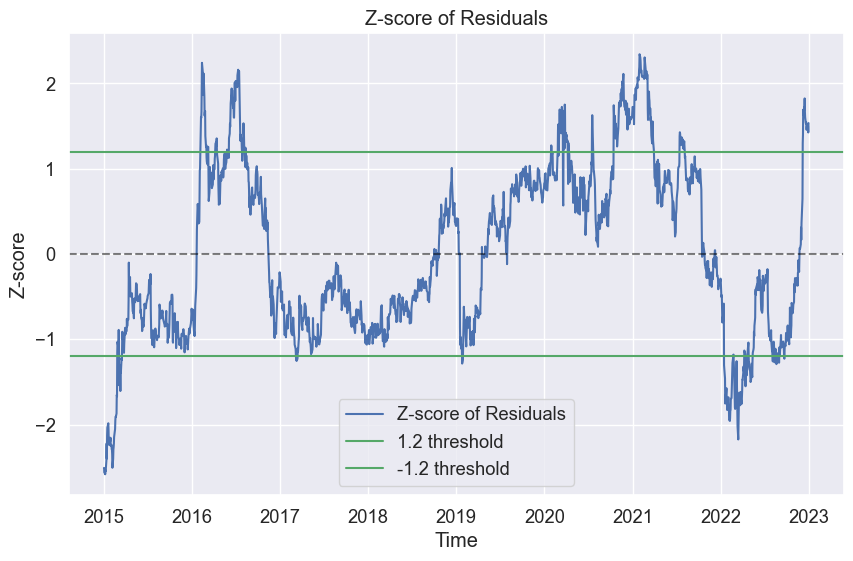

In [116]:
z_score = (error - np.mean(error)) / np.std(error)

# Plot Z-score
plt.figure(figsize=(10, 6))
plt.plot(z_score, label=f"Z-score of Residuals")
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)  # Adding a horizontal line at zero
plt.title('Z-score of Residuals')
plt.xlabel('Time')
plt.ylabel('Z-score')
plt.axhline(y=1.2,color='g',label='1.2 threshold')
plt.axhline(y=-1.2,color='g',label='-1.2 threshold')
plt.legend()
plt.grid(True)
plt.show()

# Pairs trading trading rules 

In [117]:


btest = pd.DataFrame()

btest["stock2"] = stock2_data["Close"]
btest["stock1"] = stock1_data["Close"]



btest["short signal"] = (zscore > signal_entry) & (zscore.shift(1) < signal_entry)
btest["short exit"] = (zscore < signal_exit) & (zscore.shift(1) > signal_exit)

btest["long signal"] = (zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)
btest["long exit"] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)


In [118]:
spread_side = None
counter = -1
backtest_result = []
indicator = 0

for time, signals_stock in btest.iterrows():
    counter += 1
    stock2_, stock1_, short_signal, short_exit, long_signal, long_exit = signals_stock

    if spread_side == None:
        return_stock2 = 0
        return_stock1 = 0
        backtest_result.append([time, return_stock2, return_stock1, spread_side])

        if short_signal == True:
            spread_side = "short"
        elif long_signal == True:
            spread_side = "long"

    elif spread_side == "long":
        return_stock2 = btest["stock2"][counter] / btest["stock2"][counter - 1] - 1
        return_stock1 = btest["stock1"][counter] / btest["stock1"][counter - 1] - 1
        backtest_result.append([time, return_stock2, -return_stock1, spread_side])

        if long_exit == True:
            spread_side = None

    elif spread_side == "short":
        return_stock2 = btest["stock2"][counter] / btest["stock2"][counter - 1] - 1
        return_stock1 = btest["stock1"][counter] / btest["stock1"][counter - 1] - 1
        backtest_result.append([time, -return_stock2, return_stock1, spread_side])

        if short_exit == True:
            spread_side = None


# backtesting

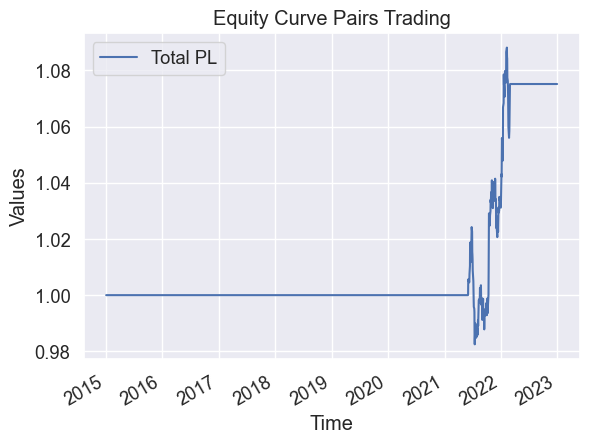

In [119]:
backtest_pandas = pd.DataFrame(backtest_result)
backtest_pandas.columns = ["Date", "stock2", "stock1", "Side"]

backtest_pandas["stock2 PL"] = np.cumprod(backtest_pandas["stock2"] + 1.)
backtest_pandas["stock1 PL"] = np.cumprod(backtest_pandas["stock1"] + 1.)
backtest_pandas["Total PL"] = (backtest_pandas["stock1 PL"] + backtest_pandas["stock2 PL"]) / 2.
backtest_pandas.index = backtest_pandas["Date"]

backtest_pandas[["Total PL"]].plot(label="Evolution Profit and Loss")
plt.title("Equity Curve Pairs Trading")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()


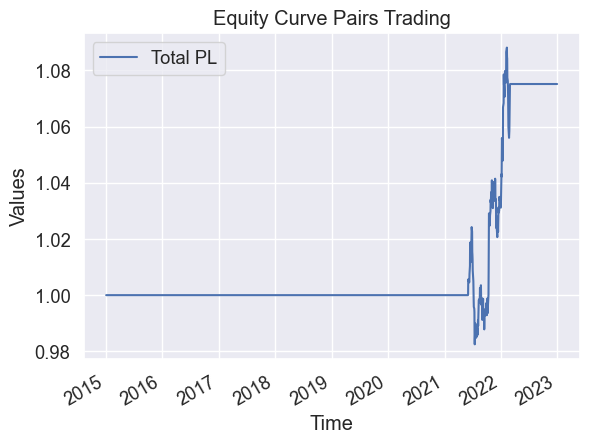

Total Return: 7.52%
Annualized Return: 0.91%
Annualized Volatility: 1.84%
Sharpe Ratio: -0.59
Maximum Drawdown: -4.08%


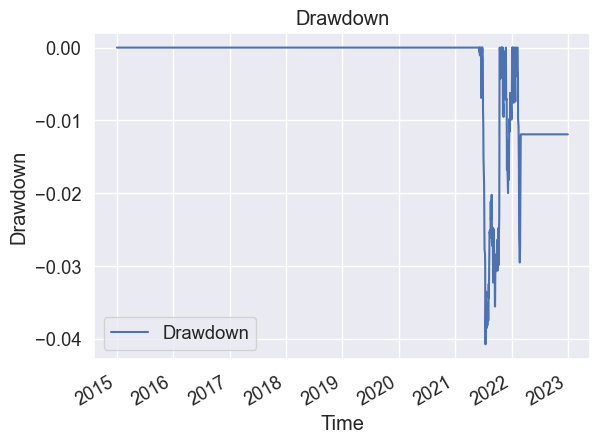

In [120]:




# Create DataFrame from backtest results
backtest_pandas = pd.DataFrame(backtest_result)
backtest_pandas.columns = ["Date", "stock2", "stock1", "Side"]

# Calculate cumulative product for P&L
backtest_pandas["stock2 PL"] = np.cumprod(backtest_pandas["stock2"] + 1.)
backtest_pandas["stock1 PL"] = np.cumprod(backtest_pandas["stock1"] + 1.)
backtest_pandas["Total PL"] = (backtest_pandas["stock1 PL"] + backtest_pandas["stock2 PL"]) / 2.
backtest_pandas.index = backtest_pandas["Date"]

# Plot the equity curve
backtest_pandas[["Total PL"]].plot(label="Evolution Profit and Loss")
plt.title("Equity Curve Pairs Trading")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()

# Calculate performance metrics
total_return = backtest_pandas["Total PL"].iloc[-1] - 1
annualized_return = (1 + total_return) ** (252 / len(backtest_pandas)) - 1

daily_returns = backtest_pandas["Total PL"].pct_change().dropna()
annualized_volatility = daily_returns.std() * np.sqrt(252)

risk_free_rate = 0.02  # Assume 2% risk-free rate
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

rolling_max = backtest_pandas["Total PL"].cummax()
drawdown = (backtest_pandas["Total PL"] - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Print performance metrics
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

# Plot drawdown
plt.figure()
drawdown.plot(label='Drawdown')
plt.title('Drawdown')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.show()
